In [ ]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from glob import glob
import os
import torchaudio

In [95]:
# Generating a clean sine wave 
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

In [96]:
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

In [97]:
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [98]:
train_inp[0].shape

(100,)

In [102]:
# Storing predictions per iterations to visualise later
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    print(inp.shape)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

torch.Size([8000, 100, 1])


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [147]:
datapath = 'C:/Users/Yoon/Desktop/daniel_1sec'

In [148]:
target_wavpath = sorted(glob(os.path.join(datapath, f'all_mono_*.wav')), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

In [149]:
input_wavpath = sorted(glob(os.path.join(datapath, f'daniel_1sec_reconall_mono_*.wavdaniel_recon_10sec.wav')), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

In [150]:
data_out = []
data_inp = []

for wave in target_wavpath:
    wav, rate = torchaudio.load(wave, normalize=False)
    data_out.append(wav[0])

for wave in input_wavpath:
    wav, rate = torchaudio.load(wave, normalize=False)
    data_inp.append(wav[0])

In [151]:
train_inp, train_out = data_inp[:125], data_out[:125]
test_inp, test_out = data_inp[125:], data_out[125:]

In [152]:
train_inp[0].shape

torch.Size([48000])

In [153]:
train_inp = torch.stack(train_inp, dim=0)
train_out = torch.stack(train_out, dim=0)
test_inp = torch.stack(test_inp, dim=0)
test_out = torch.stack(test_out, dim=0)

In [154]:
train_inp.shape

torch.Size([125, 48000])

In [155]:
train_inp = train_inp.unsqueeze(2)
train_out = train_out.unsqueeze(2)
test_inp = test_inp.unsqueeze(2)
test_out = test_out.unsqueeze(2)

In [142]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)
r

c:\users\yoon\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CustomRNN(
  (rnn): GRU(1, 30, batch_first=True, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

In [145]:
# Storing predictions per iterations to visualise later
import torch.nn.functional as F
from tqdm import tqdm
predictions = []
total_steps = 1001
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

with tqdm(range(total_steps)) as pbar:
    for step in pbar:
        hidden = None
        inp = Variable(train_inp, requires_grad=True)
        out = Variable(train_out)
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.numpy())
        loss = loss_func(pred, out)
        pbar.set_postfix({'loss': loss.item()})
        
        loss.backward()
        optimizer.step()

  0%|                                                                           | 0/1001 [03:05<?, ?it/s, loss=1.71e+3]


KeyboardInterrupt: 

In [121]:
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [129]:
t_inp.shape, pred_t.shape

(torch.Size([30, 48000, 1]), torch.Size([30, 48000, 1]))

In [122]:
# Test loss
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=short, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

Text(0.5, 1.0, 'Sample num: 15')

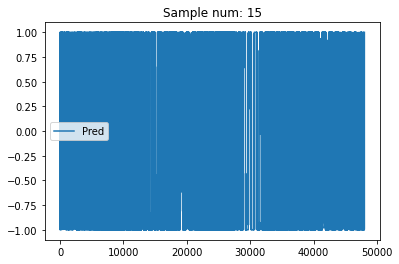

In [159]:
sample_num = 15
plt.plot(pred_t[sample_num].data.numpy(), label='Pred')
#plt.plot(test_out[sample_num], label='GT')
plt.legend()
plt.title("Sample num: {}".format(sample_num))

In [165]:
pred_t.shape

torch.Size([30, 48000, 1])

In [169]:
pred_t[15].permute(1,0).shape

torch.Size([1, 48000])

In [180]:
import IPython
IPython.display.Audio(data=pred_t[19].permute(1,0).detach().numpy(), rate=48000)